In [2]:
# load omit information
import csv
import pandas as pd
omit_info = pd.read_csv("results/dataset/response_info_omit.csv")

In [3]:
# load eval information
N_SAMPLES = 50
eval_list = []
for i in range(N_SAMPLES):
    sample_number = i + 1
    eval_info = pd.read_csv("results/dataset/responses" + str(sample_number) + "eval.csv")
    eval_list.append(eval_info)

In [5]:
# drop duplication between omit and eval
omit_user_list = omit_info["作業者"].tolist()
dropped_list = []
for i in range(N_SAMPLES):
    duplicate_user_indices = []
    for index, row in eval_list[i].iterrows():
        username = row['表示名（例：maekawa_4a0a）']
        if username in omit_user_list:
            duplicate_user_indices.append(index)
    
    dropped_list.append(eval_list[i].drop(duplicate_user_indices))

In [6]:
# drop duplication within the same survey
cleaned_list = []
for i in range(N_SAMPLES):
    cleaned_list.append(
        dropped_list[i].drop_duplicates(
            subset='表示名（例：maekawa_4a0a）',
            ignore_index=True
        )
    )

In [7]:
# drop username and save csv
for i in range(N_SAMPLES):
    sample_number = i + 1
    cleaned_info = cleaned_list[i].drop('表示名（例：maekawa_4a0a）', axis=1)
    cleaned_info.to_csv("results/dataset/responses" + str(sample_number) + "cleaned.csv")

In [4]:
# calculate average ratings
import statistics

def average_without_max_and_min(rating_list):
    n = len(rating_list)
    if n == 0:
        return None
    if n == 1 or n == 2:
        return statistics.mean(rating_list)
    if n >= 3:
        rating_list.remove(max(rating_list))
        rating_list.remove(min(rating_list))
        return statistics.mean(rating_list)
    
def average_without_min(rating_list):
    n = len(rating_list)
    if n == 0:
        return None
    if n == 1:
        return rating_list[0]
    if n >= 2:
        rating_list.remove(min(rating_list))
        return statistics.mean(rating_list)
    
def std_without_min(rating_list):
    n = len(rating_list)
    if n == 0 or n == 1:
        return None
    if n == 2:
        return statistics.stdev(rating_list)
    if n >= 3:
        rating_list.remove(min(rating_list))
        return statistics.stdev(rating_list)

In [5]:
# concatenate data
concat_data = pd.DataFrame()

for i in range(N_SAMPLES):
    sample_number = i + 1
    eval_info = pd.read_csv("forms/dataset{:03}eval.csv".format(sample_number))
    response = pd.read_csv("results/dataset/responses" + str(sample_number) + "cleaned.csv")
    res_index = 3
    for index, row in eval_info.iterrows():
        avg_ratings = []
        number_of_responses = int(row['nor'])
        for exp_index in range(number_of_responses):
            ratings = response.iloc[:, res_index]
            avg_rating = average_without_max_and_min(ratings.tolist())
            avg_ratings.append(avg_rating)
            res_index += 1
        columns = ['avg' + str(j) for j in range(number_of_responses)]
        avg_data = pd.DataFrame([avg_ratings], columns=columns)
        avg_of_avg = average_without_min(avg_ratings)
        avg_frame = pd.DataFrame([avg_of_avg], columns=['average'])
        std_of_avg = std_without_min(avg_ratings)
        std_frame = pd.DataFrame([std_of_avg], columns=['stdev'])
        info_frame = pd.DataFrame([row])
        info_frame.reset_index(inplace=True)
        combined_data = pd.concat([info_frame, avg_data, avg_frame, std_frame], axis=1)
        concat_data = pd.concat([concat_data, combined_data])

In [18]:
# show statistics
print(concat_data.describe())

            index  Unnamed: 0        turn  similarity         nor        avg0  \
count  952.000000       952.0  952.000000  952.000000  952.000000  952.000000   
mean     9.065126         0.0    7.289916    0.927602   10.663866    5.980200   
std      5.575970         0.0    2.790623    0.046149    0.987001    2.346587   
min      0.000000         0.0    3.000000    0.774878    8.000000    0.000000   
25%      4.000000         0.0    5.000000    0.900053   10.000000    4.125000   
50%      9.000000         0.0    7.000000    0.933984   10.000000    6.250000   
75%     14.000000         0.0   10.000000    0.961876   11.000000    8.000000   
max     23.000000         0.0   15.000000    1.000000   13.000000    9.666667   

             avg1        avg2        avg3        avg4        avg5        avg6  \
count  952.000000  952.000000  952.000000  952.000000  952.000000  952.000000   
mean     6.188113    5.896945    5.744336    5.468986    5.570652    5.550922   
std      2.260201    2.1707

In [8]:
# test correlation
from scipy.stats import pearsonr
similarity = concat_data['similarity'].values
average = concat_data['average'].values
stdev = concat_data['stdev'].values

corr_avg, p_avg = pearsonr(similarity, average)
print("correlation between similarity and average rating:")
print("r =", corr_avg, ", p =", p_avg)
corr_std, p_std = pearsonr(similarity, stdev)
print("correlation between similarity and stdev rating:")
print("r =", corr_std, ", p =", p_std)

correlation between similarity and average rating:
r = 0.37445124937351953 , p = 4.7022215286959936e-33
correlation between similarity and stdev rating:
r = -0.019257781411167525 , p = 0.5528709761463023


(0.0, 10.0)

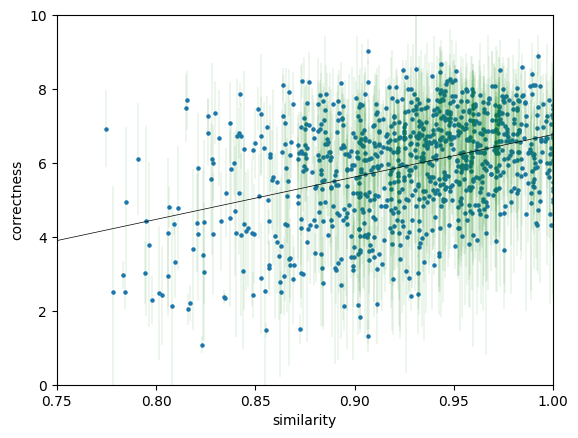

In [9]:
# draw scatter plot
import matplotlib.pyplot as plt
import numpy as np

xlimit = [0.75, 1]
plt.errorbar(similarity, average, yerr=stdev, fmt='o', markersize=0, elinewidth=0.1, ecolor='green')
plt.scatter(similarity, average, s=5)
b, a = np.polyfit(similarity, average, deg=1)
xseq = np.linspace(xlimit[0], xlimit[1], num=100)
plt.plot(xseq, a + b * xseq, color='k', lw=0.5)
plt.xlabel('similarity')
plt.ylabel('correctness')
plt.xlim(xlimit)
plt.ylim([0, 10])

In [17]:
# find outliers
concat_data['error'] = concat_data['average'] - a - b * concat_data['similarity']
concat_data = concat_data.sort_values('error')
under_correct = concat_data.head()
for index, row in under_correct.iterrows():
    print("-----------------")
    print("under correct case")
    print("filename:", row['filename'])
    print("turn:", row['turn'])
    print("complete dialogue:")
    print(row['complete_dialogue'])
    print("similarity:", row['similarity'])
    for i in range(int(row['nor'])):
        print("sentence", i, ":", row['res' + str(i)])
    print("predicted correctness:", a + b * row['similarity'])
    print("average correctness:", row['average'])
    print("stdev correctness:", row['stdev'])
over_correct = concat_data.tail()
for index, row in over_correct.iterrows():
    print("-----------------")
    print("over correct case")
    print("filename:", row['filename'])
    print("turn:", row['turn'])
    print("complete dialogue:")
    print(row['complete_dialogue'])
    print("similarity:", row['similarity'])
    for i in range(int(row['nor'])):
        print("sentence", i, ":", row['res' + str(i)])
    print("predicted correctness:", a + b * row['similarity'])
    print("average correctness:", row['average'])
    print("stdev correctness:", row['stdev'])


-----------------
under correct case
filename: PP66.txt
turn: 7
complete dialogue:
A: わたしは今川のそばに住んでるんですけど、よかったら遊びにきませんか？

B: いいですねー。川のそばだと、夏は風が通って涼しそうですね！

A: そうなんですよ。団地暮らしになるんですが立地がよかったもんでここに移ってきたんです。

B: なるほど！団地のように集合住宅だと、冬も暖かいって聞きます。保険の外交で団地にはよく行きますが、みなさん、狭くても上手に工夫されて住んでますよね！

A: そうなんですよ。わたし集中力があるので没頭すると耳に音が入ってこないので騒音で悩まされたこともないですし。あなたは実家ですか？

B: いえ、実家ではないのですが、実家と同じ広島県内に住んでますよ！

A: そうでしたか！広島もいいところですよね。

B: はい！なんと言っても、お好み焼きが美味しいですしねー！

A: わたしの尊敬する人が坂本龍馬なもんでよく四国のあたりを旅行するんですが、お好み焼きもそうで寿司本当に美味しいものが多いですよね。

B: ええ、本当に。でも、お好み焼きって料理の1つに数えていいんですかね？わたし、お好み焼き以外は、料理全般、苦手なんです。

A: お好み焼きが十分料理に数えていいでしょう！切って混ぜて焼くんですから！

B: たしかに！これからは料理できるって、人に言うことにします！

A: いや、お好み焼きだけでそれは言い過ぎかもしれません、、
similarity: 0.906648080494622
sentence 0 : 実家に住むメリットが正直思い浮かばなかった。それでも話を続けるために少しボケた回答をした。
sentence 1 : 実家住みです。実家で作ってくれるお好みが美味しいし最高。
sentence 2 : 遊びにきませんか？に対しての返答。今川はお好み焼きがおいしい事で有名。
sentence 3 : 実家暮らしかどうかを問われて、自身が実家に住んでいることを説明したうえで、自分の実家はお好み焼き屋をしており、お好み焼きがおいしいので実家を離れられない説明をしている。
sentence 4 : 実家に住んでいると回答をしている。お好み焼きが美味しいこと